### Necessary Packages

In [1]:
import sys
import os
import torch
import pandas as pd
sys.path.append('../..')
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from src.utils import load, load_checkpoint, seed_everything, score
from src.training.cnn_k_fold import create_dataloaders,create_network,Config
from src.models import ResNet
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,auc,roc_curve,roc_auc_score
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from definitions import *
from functools import reduce

### Global

In [2]:
EXPIREMENT_NAME = 'resnext'
EXPIREMENT_PATH = os.path.join(EXPIREMENTS_DIR,EXPIREMENT_NAME)
CHECKPOINTS_PATH = os.path.join(EXPIREMENT_PATH,'checkpoints')
CONFIG_PATH = os.path.join(EXPIREMENT_PATH,'config.json')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load configurations

In [3]:
config = Config(**load(CONFIG_PATH))
loaders,test_loader = create_dataloaders(config)

### Reproducibility

In [4]:
seed_everything(config.seed)

### Models loading

In [5]:
def create_models(checkpoints_path : str):

    models = []
    files = sorted(os.listdir(CHECKPOINTS_PATH), key=lambda x: int(x.split('_')[-1].split('.')[0]))

    for i,checkpoint in enumerate(tqdm(files)):

        model = create_network(config)
        checkpoint = load_checkpoint(os.path.join(checkpoints_path, checkpoint), f'checkpoint_fold={i}.pt')
        model.load_state_dict(checkpoint['model'])
        model.to(DEVICE)
        model.eval()
        models.append(model)

    return models

In [6]:
models = create_models(CHECKPOINTS_PATH)

  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
### Save the models
for i,model in enumerate(models):
    torch.save(model.state_dict(),os.path.join(EXPIREMENT_PATH,f'model_fold={i}.pth'))

### Make predictions on individual folds

In [8]:
def predict(model: ResNet, dataloader: DataLoader):

    model.eval()

    y_true = []
    y_pred = []

    for x,y in tqdm(dataloader):

        x = x.to(DEVICE)
        y_hat = model.predict(x).detach().cpu().numpy()

        y_true.extend(y.numpy())
        y_pred.extend(y_hat)

    return y_true,y_pred

In [9]:
def predict_all(models: list, dataloaders: list[DataLoader] | DataLoader):
    
    results = {}

    for i,model in enumerate(models):

        if isinstance(dataloaders,list):
            dataloader = dataloaders[i]
        else:
            dataloader = dataloaders

        y_true,y_pred = predict(model,dataloader)

        results[f'fold_{i}'] = pd.DataFrame({
            'y_true': y_true,
            'y_pred': y_pred
        })

    return results

In [10]:
result = predict_all(models,list((val_loader for _,val_loader in loaders)))

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

In [11]:
result['fold_0'].head()

,y_true,y_pred
0,0.0,9.136698e-08
1,0.0,4.786759e-04
2,0.0,1.483607e-02
3,0.0,2.545639e-06
4,0.0,1.321754e-05


### Calculate Fold-metrics

In [12]:
def calculate_metrics(y_true : np.ndarray,y_hard : np.ndarray,y_prob : np.ndarray) -> pd.Series:

    accuracy = accuracy_score(y_true,y_hard)
    f1 = f1_score(y_true,y_hard)
    precision = precision_score(y_true,y_hard)
    recall = recall_score(y_true,y_hard)
    roc_auc = roc_auc_score(y_true,y_prob)
    pauc = score(y_true,y_prob)

    results = {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'pauc': pauc
    }

    return pd.Series(results)

In [13]:
def calculate_all_metrics(result: dict[str,pd.DataFrame]) -> pd.DataFrame:

    metrics = []

    for fold in result.keys():

        y_true = result[fold]['y_true']
        y_pred = np.int32(result[fold]['y_pred'] > 0.5)
        y_prob = result[fold]['y_pred']

        fold_result = calculate_metrics(y_true,y_pred,y_prob)
        fold_result.name = fold

        metrics.append(fold_result)

    metrics = pd.DataFrame(metrics)

    means = metrics.mean(axis=0)
    stds = metrics.std(axis=0)
    metrics.loc['mean'] = means
    metrics.loc['std'] = stds

    return metrics

In [14]:
fold_metrics = calculate_all_metrics(result)

In [15]:
fold_metrics

,accuracy,f1,precision,recall,roc_auc,pauc
fold_0,0.975959,0.033674,0.017478,0.459016,0.878395,0.117352
fold_1,0.975600,0.046756,0.024450,0.533333,0.887761,0.111597
fold_2,0.992400,0.048689,0.027311,0.224138,0.893119,0.125653
fold_3,0.980237,0.057102,0.030211,0.519481,0.921673,0.140508
fold_4,0.981419,0.037209,0.019576,0.375000,0.872693,0.112543
mean,0.981123,0.044686,0.023805,0.422194,0.890728,0.121531
std,0.006805,0.009376,0.005284,0.127108,0.019036,0.011980


<Axes: ylabel='pauc'>

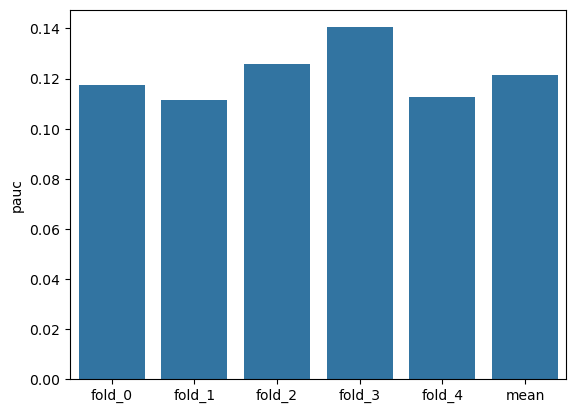

In [16]:
sns.barplot(fold_metrics['pauc'].drop('std'))

### Calculate test-set metrics

In [17]:
test_result = predict_all(models,test_loader)

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

In [18]:
test_result['fold_0'].head()

,y_true,y_pred
0,0.0,2.749417e-06
1,0.0,4.101090e-08
2,0.0,4.551074e-05
3,0.0,5.332190e-10
4,0.0,2.461496e-01


In [19]:
test_metrics = calculate_all_metrics(test_result)

In [20]:
test_metrics

,accuracy,f1,precision,recall,roc_auc,pauc
fold_0,0.972159,0.018977,0.009788,0.310345,0.875833,0.121220
fold_1,0.973266,0.025095,0.012958,0.396552,0.878451,0.113461
fold_2,0.990994,0.029032,0.016014,0.155172,0.843698,0.100893
fold_3,0.979325,0.030856,0.016082,0.379310,0.906062,0.138865
fold_4,0.979385,0.030942,0.016129,0.379310,0.880485,0.117158
mean,0.979025,0.026981,0.014194,0.324138,0.876906,0.118319
std,0.007480,0.005063,0.002809,0.100089,0.022188,0.013776


<Axes: ylabel='pauc'>

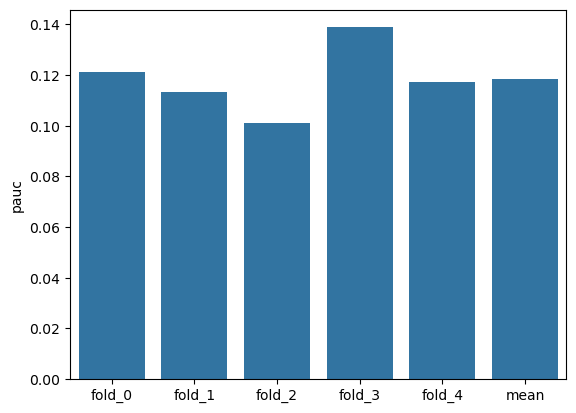

In [21]:
sns.barplot(test_metrics['pauc'].drop('std'))

### The mean of the models

In [22]:
mean = reduce(lambda a,b : a+b,(test_result[key]['y_pred'] for key in test_result.keys())) / len(test_result.keys())

In [23]:
mean_metrcis = calculate_metrics(test_result['fold_0']['y_true'],np.int32(mean > 0.5),mean)
mean_metrcis.name = 'mean'
mean_metrcis

accuracy     0.990904
f1           0.050000
precision    0.027491
recall       0.275862
roc_auc      0.909527
pauc         0.138643
Name: mean, dtype: float64